# Method 6 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

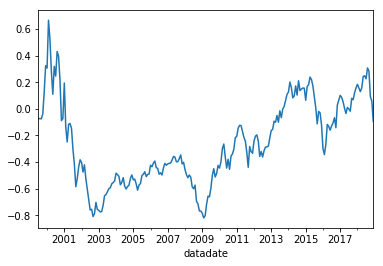

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.323398
2000-12-31   -0.299740
2001-12-31   -0.333531
2002-12-31   -0.603262
2003-12-31    0.872077
2004-12-31    0.099175
2005-12-31    0.014166
2006-12-31    0.128432
2007-12-31    0.036952
2008-12-31   -0.609511
2009-12-31    1.461818
2010-12-31    0.362499
2011-12-31   -0.149746
2012-12-31    0.173443
2013-12-31    0.417960
2014-12-31    0.041578
2015-12-31   -0.238312
2016-12-31    0.208861
2017-12-31    0.087302
2018-12-31   -0.217157
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     289.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-88
Time:                        14:27:47   Log-Likelihood:                 395.94
No. Observations:                 234   AIC:                            -781.9
Df Residuals:                     229   BIC:                            -764.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.003      0.756      0.451      -0.004       0.008
mktrf          1.4250      0.084     16.963      0.000       1.259       1.591
me             0.6062      0.098      6.204      0.000       0.414       0.799
ia            -0.0730      0.149     -0.492      0.623      -0.366       0.220
roe           -1.2943      0.127    -10.181      0.000      -1.545      -1.044
==============================================================================
Omnibus:                      128.097   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1492.139
Skew:                           1.856   Prob(JB):                         0.00
Kurtosis:                      14.801   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     111.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-52
Time:                        14:27:47   Log-Likelihood:                 395.94
No. Observations:                 234   AIC:                            -781.9
Df Residuals:                     229   BIC:                            -764.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.003      0.762      0.446      -0.004       0.008
mktrf          1.4250      0.159      8.976      0.000       1.114       1.736
me             0.6062      0.109      5.580      0.000       0.393       0.819
ia            -0.0730      0.216     -0.339      0.735      -0.496       0.350
roe           -1.2943      0.225     -5.760      0.000      -1.735      -0.854
==============================================================================
Omnibus:                      128.097   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1492.139
Skew:                           1.856   Prob(JB):                         0.00
Kurtosis:                      14.801   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     126.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.88e-57
Time:                        14:27:47   Log-Likelihood:                 395.94
No. Observations:                 234   AIC:                            -781.9
Df Residuals:                     229   BIC:                            -764.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.003      0.745      0.456      -0.004       0.008
mktrf          1.4250      0.162      8.783      0.000       1.107       1.743
me             0.6062      0.126      4.824      0.000       0.360       0.852
ia            -0.0730      0.209     -0.350      0.727      -0.482       0.336
roe           -1.2943      0.235     -5.496      0.000      -1.756      -0.833
==============================================================================
Omnibus:                      128.097   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1492.139
Skew:                           1.856   Prob(JB):                         0.00
Kurtosis:                      14.801   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.60e-82
Time:                        14:27:47   Log-Likelihood:                 383.52
No. Observations:                 234   AIC:                            -755.0
Df Residuals:                     228   BIC:                            -734.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.376      0.707      -0.005       0.008
mktrf          1.5610      0.089     17.549      0.000       1.386       1.736
smb            0.6253      0.117      5.328      0.000       0.394       0.857
hml            0.1535      0.138      1.109      0.268      -0.119       0.426
rmw           -1.1877      0.156     -7.591      0.000      -1.496      -0.879
cma            0.0533      0.199      0.268      0.789      -0.339       0.445
==============================================================================
Omnibus:                      120.788   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.706
Skew:                           1.918   Prob(JB):                    6.19e-184
Kurtosis:                      11.474   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     137.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-66
Time:                        14:27:47   Log-Likelihood:                 383.52
No. Observations:                 234   AIC:                            -755.0
Df Residuals:                     228   BIC:                            -734.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.387      0.699      -0.005       0.008
mktrf          1.5610      0.100     15.660      0.000       1.366       1.756
smb            0.6253      0.123      5.072      0.000       0.384       0.867
hml            0.1535      0.264      0.581      0.561      -0.364       0.671
rmw           -1.1877      0.229     -5.184      0.000      -1.637      -0.739
cma            0.0533      0.324      0.165      0.869      -0.581       0.688
==============================================================================
Omnibus:                      120.788   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.706
Skew:                           1.918   Prob(JB):                    6.19e-184
Kurtosis:                      11.474   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     155.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-71
Time:                        14:27:47   Log-Likelihood:                 383.52
No. Observations:                 234   AIC:                            -755.0
Df Residuals:                     228   BIC:                            -734.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.369      0.712      -0.005       0.008
mktrf          1.5610      0.090     17.253      0.000       1.384       1.738
smb            0.6253      0.124      5.055      0.000       0.383       0.868
hml            0.1535      0.233      0.660      0.509      -0.302       0.609
rmw           -1.1877      0.245     -4.857      0.000      -1.667      -0.708
cma            0.0533      0.312      0.171      0.864      -0.558       0.665
==============================================================================
Omnibus:                      120.788   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.706
Skew:                           1.918   Prob(JB):                    6.19e-184
Kurtosis:                      11.474   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     256.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-83
Time:                        14:27:47   Log-Likelihood:                 384.24
No. Observations:                 234   AIC:                            -758.5
Df Residuals:                     229   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.604      0.547      -0.008       0.004
mktrf          1.6173      0.081     19.891      0.000       1.457       1.778
smb            1.1921      0.101     11.745      0.000       0.992       1.392
hml           -0.1408      0.101     -1.397      0.164      -0.339       0.058
umd           -0.4959      0.066     -7.497      0.000      -0.626      -0.366
==============================================================================
Omnibus:                      102.181   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.135
Skew:                           1.524   Prob(JB):                    3.19e-166
Kurtosis:                      11.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.00e-65
Time:                        14:27:47   Log-Likelihood:                 384.24
No. Observations:                 234   AIC:                            -758.5
Df Residuals:                     229   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.650      0.516      -0.008       0.004
mktrf          1.6173      0.128     12.671      0.000       1.367       1.868
smb            1.1921      0.101     11.758      0.000       0.993       1.391
hml           -0.1408      0.166     -0.847      0.397      -0.467       0.185
umd           -0.4959      0.106     -4.671      0.000      -0.704      -0.288
==============================================================================
Omnibus:                      102.181   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.135
Skew:                           1.524   Prob(JB):                    3.19e-166
Kurtosis:                      11.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     146.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.88e-62
Time:                        14:27:47   Log-Likelihood:                 384.24
No. Observations:                 234   AIC:                            -758.5
Df Residuals:                     229   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.645      0.519      -0.008       0.004
mktrf          1.6173      0.126     12.842      0.000       1.371       1.864
smb            1.1921      0.101     11.765      0.000       0.994       1.391
hml           -0.1408      0.161     -0.873      0.383      -0.457       0.175
umd           -0.4959      0.105     -4.714      0.000      -0.702      -0.290
==============================================================================
Omnibus:                      102.181   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.135
Skew:                           1.524   Prob(JB):                    3.19e-166
Kurtosis:                      11.299   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     137.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-43
Time:                        14:27:47   Log-Likelihood:                 181.60
No. Observations:                 120   AIC:                            -353.2
Df Residuals:                     115   BIC:                            -339.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.005      1.182      0.240      -0.004       0.016
mktrf          1.3247      0.140      9.443      0.000       1.047       1.603
me             0.4862      0.139      3.509      0.001       0.212       0.761
ia            -0.2937      0.217     -1.354      0.178      -0.723       0.136
roe           -1.3330      0.192     -6.942      0.000      -1.713      -0.953
==============================================================================
Omnibus:                       56.073   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.716
Skew:                           1.443   Prob(JB):                     8.38e-71
Kurtosis:                      10.498   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     111.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-38
Time:                        14:27:47   Log-Likelihood:                 181.60
No. Observations:                 120   AIC:                            -353.2
Df Residuals:                     115   BIC:                            -339.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.380      0.168      -0.003       0.015
mktrf          1.3247      0.247      5.359      0.000       0.840       1.809
me             0.4862      0.147      3.303      0.001       0.198       0.775
ia            -0.2937      0.296     -0.993      0.321      -0.874       0.286
roe           -1.3330      0.315     -4.235      0.000      -1.950      -0.716
==============================================================================
Omnibus:                       56.073   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.716
Skew:                           1.443   Prob(JB):                     8.38e-71
Kurtosis:                      10.498   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     131.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.31e-42
Time:                        14:27:48   Log-Likelihood:                 181.60
No. Observations:                 120   AIC:                            -353.2
Df Residuals:                     115   BIC:                            -339.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.529      0.126      -0.002       0.014
mktrf          1.3247      0.258      5.141      0.000       0.820       1.830
me             0.4862      0.165      2.950      0.003       0.163       0.809
ia            -0.2937      0.277     -1.062      0.288      -0.836       0.248
roe           -1.3330      0.341     -3.912      0.000      -2.001      -0.665
==============================================================================
Omnibus:                       56.073   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.716
Skew:                           1.443   Prob(JB):                     8.38e-71
Kurtosis:                      10.498   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     96.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-39
Time:                        14:27:48   Log-Likelihood:                 175.93
No. Observations:                 120   AIC:                            -339.9
Df Residuals:                     114   BIC:                            -323.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.006      1.160      0.249      -0.005       0.018
mktrf          1.6313      0.156     10.473      0.000       1.323       1.940
smb            0.5421      0.176      3.073      0.003       0.193       0.892
hml           -0.1363      0.216     -0.631      0.529      -0.565       0.292
rmw           -1.0053      0.255     -3.944      0.000      -1.510      -0.500
cma            0.1029      0.279      0.368      0.713      -0.450       0.656
==============================================================================
Omnibus:                       65.489   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.765
Skew:                           1.900   Prob(JB):                     3.26e-63
Kurtosis:                       9.566   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     53.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-28
Time:                        14:27:48   Log-Likelihood:                 175.93
No. Observations:                 120   AIC:                            -339.9
Df Residuals:                     114   BIC:                            -323.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.004      1.572      0.116      -0.002       0.015
mktrf          1.6313      0.173      9.416      0.000       1.292       1.971
smb            0.5421      0.174      3.110      0.002       0.200       0.884
hml           -0.1363      0.263     -0.519      0.604      -0.651       0.378
rmw           -1.0053      0.306     -3.287      0.001      -1.605      -0.406
cma            0.1029      0.353      0.291      0.771      -0.589       0.795
==============================================================================
Omnibus:                       65.489   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.765
Skew:                           1.900   Prob(JB):                     3.26e-63
Kurtosis:                       9.566   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     64.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.61e-31
Time:                        14:27:48   Log-Likelihood:                 175.93
No. Observations:                 120   AIC:                            -339.9
Df Residuals:                     114   BIC:                            -323.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.004      1.718      0.086      -0.001       0.014
mktrf          1.6313      0.141     11.582      0.000       1.355       1.907
smb            0.5421      0.163      3.334      0.001       0.223       0.861
hml           -0.1363      0.254     -0.537      0.591      -0.634       0.361
rmw           -1.0053      0.333     -3.016      0.003      -1.659      -0.352
cma            0.1029      0.326      0.316      0.752      -0.536       0.742
==============================================================================
Omnibus:                       65.489   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.765
Skew:                           1.900   Prob(JB):                     3.26e-63
Kurtosis:                       9.566   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     136.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-42
Time:                        14:27:48   Log-Likelihood:                 181.33
No. Observations:                 120   AIC:                            -352.7
Df Residuals:                     115   BIC:                            -338.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.005      0.479      0.633      -0.008       0.013
mktrf          1.6393      0.124     13.235      0.000       1.394       1.885
smb            1.0980      0.141      7.786      0.000       0.819       1.377
hml           -0.4047      0.141     -2.865      0.005      -0.684      -0.125
umd           -0.4751      0.087     -5.455      0.000      -0.648      -0.303
==============================================================================
Omnibus:                       54.951   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.601
Skew:                           1.479   Prob(JB):                     7.79e-59
Kurtosis:                       9.691   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     147.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-44
Time:                        14:27:48   Log-Likelihood:                 181.33
No. Observations:                 120   AIC:                            -352.7
Df Residuals:                     115   BIC:                            -338.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.004      0.626      0.531      -0.005       0.010
mktrf          1.6393      0.186      8.814      0.000       1.275       2.004
smb            1.0980      0.124      8.832      0.000       0.854       1.342
hml           -0.4047      0.203     -1.992      0.046      -0.803      -0.006
umd           -0.4751      0.109     -4.366      0.000      -0.688      -0.262
==============================================================================
Omnibus:                       54.951   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.601
Skew:                           1.479   Prob(JB):                     7.79e-59
Kurtosis:                       9.691   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     175.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.77e-48
Time:                        14:27:48   Log-Likelihood:                 181.33
No. Observations:                 120   AIC:                            -352.7
Df Residuals:                     115   BIC:                            -338.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.004      0.674      0.500      -0.005       0.010
mktrf          1.6393      0.191      8.580      0.000       1.265       2.014
smb            1.0980      0.123      8.952      0.000       0.858       1.338
hml           -0.4047      0.208     -1.943      0.052      -0.813       0.004
umd           -0.4751      0.111     -4.288      0.000      -0.692      -0.258
==============================================================================
Omnibus:                       54.951   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.601
Skew:                           1.479   Prob(JB):                     7.79e-59
Kurtosis:                       9.691   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     187.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.53e-48
Time:                        14:27:48   Log-Likelihood:                 236.16
No. Observations:                 114   AIC:                            -462.3
Df Residuals:                     109   BIC:                            -448.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.311      0.756      -0.007       0.005
mktrf          1.4802      0.092     16.149      0.000       1.299       1.662
me             0.8521      0.142      6.021      0.000       0.572       1.133
ia             0.3251      0.196      1.656      0.101      -0.064       0.714
roe           -1.2846      0.172     -7.448      0.000      -1.626      -0.943
==============================================================================
Omnibus:                       38.510   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.702
Skew:                           1.248   Prob(JB):                     8.24e-23
Kurtosis:                       6.896   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     201.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.34e-49
Time:                        14:27:48   Log-Likelihood:                 236.16
No. Observations:                 114   AIC:                            -462.3
Df Residuals:                     109   BIC:                            -448.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.402      0.688      -0.006       0.004
mktrf          1.4802      0.094     15.728      0.000       1.296       1.665
me             0.8521      0.158      5.406      0.000       0.543       1.161
ia             0.3251      0.235      1.384      0.166      -0.135       0.785
roe           -1.2846      0.255     -5.038      0.000      -1.784      -0.785
==============================================================================
Omnibus:                       38.510   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.702
Skew:                           1.248   Prob(JB):                     8.24e-23
Kurtosis:                       6.896   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     225.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.76e-52
Time:                        14:27:48   Log-Likelihood:                 236.16
No. Observations:                 114   AIC:                            -462.3
Df Residuals:                     109   BIC:                            -448.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.462      0.644      -0.005       0.003
mktrf          1.4802      0.085     17.381      0.000       1.313       1.647
me             0.8521      0.183      4.652      0.000       0.493       1.211
ia             0.3251      0.267      1.218      0.223      -0.198       0.848
roe           -1.2846      0.258     -4.970      0.000      -1.791      -0.778
==============================================================================
Omnibus:                       38.510   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.702
Skew:                           1.248   Prob(JB):                     8.24e-23
Kurtosis:                       6.896   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     137.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.54e-45
Time:                        14:27:48   Log-Likelihood:                 232.33
No. Observations:                 114   AIC:                            -452.7
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.961      0.339      -0.010       0.003
mktrf          1.5217      0.091     16.755      0.000       1.342       1.702
smb            0.7871      0.147      5.339      0.000       0.495       1.079
hml            0.6184      0.188      3.288      0.001       0.246       0.991
rmw           -1.1522      0.230     -5.004      0.000      -1.609      -0.696
cma           -0.0497      0.292     -0.170      0.865      -0.629       0.530
==============================================================================
Omnibus:                       22.743   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.288
Skew:                           0.861   Prob(JB):                     1.78e-09
Kurtosis:                       5.348   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     190.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.97e-52
Time:                        14:27:48   Log-Likelihood:                 232.33
No. Observations:                 114   AIC:                            -452.7
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.897      0.370      -0.010       0.004
mktrf          1.5217      0.069     22.208      0.000       1.387       1.656
smb            0.7871      0.143      5.489      0.000       0.506       1.068
hml            0.6184      0.198      3.123      0.002       0.230       1.006
rmw           -1.1522      0.292     -3.951      0.000      -1.724      -0.581
cma           -0.0497      0.271     -0.184      0.854      -0.581       0.481
==============================================================================
Omnibus:                       22.743   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.288
Skew:                           0.861   Prob(JB):                     1.78e-09
Kurtosis:                       5.348   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     240.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.24e-57
Time:                        14:27:48   Log-Likelihood:                 232.33
No. Observations:                 114   AIC:                            -452.7
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.893      0.372      -0.010       0.004
mktrf          1.5217      0.066     22.936      0.000       1.392       1.652
smb            0.7871      0.160      4.905      0.000       0.473       1.102
hml            0.6184      0.176      3.520      0.000       0.274       0.963
rmw           -1.1522      0.263     -4.388      0.000      -1.667      -0.638
cma           -0.0497      0.296     -0.168      0.867      -0.630       0.530
==============================================================================
Omnibus:                       22.743   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.288
Skew:                           0.861   Prob(JB):                     1.78e-09
Kurtosis:                       5.348   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     150.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.85e-43
Time:                        14:27:48   Log-Likelihood:                 225.41
No. Observations:                 114   AIC:                            -440.8
Df Residuals:                     109   BIC:                            -427.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.183      0.240      -0.011       0.003
mktrf          1.5584      0.095     16.326      0.000       1.369       1.748
smb            1.0592      0.149      7.116      0.000       0.764       1.354
hml            0.6126      0.153      3.997      0.000       0.309       0.916
umd           -0.3940      0.116     -3.407      0.001      -0.623      -0.165
==============================================================================
Omnibus:                       27.065   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.225
Skew:                           0.862   Prob(JB):                     1.53e-15
Kurtosis:                       6.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     245.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-53
Time:                        14:27:48   Log-Likelihood:                 225.41
No. Observations:                 114   AIC:                            -440.8
Df Residuals:                     109   BIC:                            -427.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.319      0.187      -0.010       0.002
mktrf          1.5584      0.078     19.921      0.000       1.405       1.712
smb            1.0592      0.130      8.169      0.000       0.805       1.313
hml            0.6126      0.194      3.151      0.002       0.232       0.994
umd           -0.3940      0.119     -3.318      0.001      -0.627      -0.161
==============================================================================
Omnibus:                       27.065   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.225
Skew:                           0.862   Prob(JB):                     1.53e-15
Kurtosis:                       6.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     357.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-61
Time:                        14:27:48   Log-Likelihood:                 225.41
No. Observations:                 114   AIC:                            -440.8
Df Residuals:                     109   BIC:                            -427.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.315      0.188      -0.010       0.002
mktrf          1.5584      0.075     20.829      0.000       1.412       1.705
smb            1.0592      0.116      9.143      0.000       0.832       1.286
hml            0.6126      0.197      3.107      0.002       0.226       0.999
umd           -0.3940      0.113     -3.479      0.001      -0.616      -0.172
==============================================================================
Omnibus:                       27.065   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.225
Skew:                           0.862   Prob(JB):                     1.53e-15
Kurtosis:                       6.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""